## Lending Club analysis 

This is code for my LendingClub project. 

The project has two basic data science steps.  

1. estimating the return for each loan.
2. Optimize a portfolio of loans.

From these two steps the algorithm should produce a daily/weekly list of suggested investments.

In this analysis return is the 3-year return on each loan.

Details are in the document is **here**.

In [1]:
import pandas as pd

### Read in the data

The data are all the Q1 2017 loans.  [data should be here](https://www.lendingclub.com/statistics/additional-statistics?) but something is wrong with that link.  

In [2]:
# there is a weird first row in the dataset that needs to be skipped
# LC_raw = pd.read_csv("./data/Loan_stats_2017_top1000.csv",header=1,skiprows=0)

LC_raw = pd.read_csv("./data/LoanStats_securev1_2017Q1.csv",header=1,skiprows=0)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,118) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
LC_raw.head(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,104160129,NaN,6000.0,6000.0,6000.0,36 months,7.24%,185.93,A,A3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,104170260,NaN,17000.0,17000.0,17000.0,36 months,7.49%,528.73,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,103952006,NaN,14000.0,14000.0,14000.0,60 months,12.74%,316.69,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,103347407,NaN,9900.0,9900.0,9900.0,36 months,5.32%,298.14,A,A1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,103470623,NaN,15400.0,15400.0,15400.0,60 months,11.39%,337.84,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
5,104047067,NaN,10000.0,10000.0,10000.0,36 months,7.99%,313.32,A,A5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
6,104048642,NaN,10000.0,10000.0,10000.0,36 months,7.49%,311.02,A,A4,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
7,104280288,NaN,3025.0,3025.0,3025.0,36 months,6.99%,93.39,A,A2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
8,104070168,NaN,9000.0,9000.0,9000.0,36 months,11.39%,296.32,B,B3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
9,104210150,NaN,12000.0,12000.0,12000.0,36 months,6.99%,370.48,A,A2,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# there are also two total observations at the end causing the warning when reading in the data
LC_raw.tail(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
96776,94477589,NaN,10000.0,10000.0,10000.0,36 months,8.24%,314.48,B,B1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
96777,94048859,NaN,6325.0,6325.0,6325.0,36 months,15.99%,222.34,C,C5,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
96778,94038849,NaN,15625.0,15625.0,15625.0,60 months,28.69%,493.03,F,F1,...,NaN,NaN,NaN,Y,Oct-2018,ACTIVE,Sep-2018,6895.96,45.0,24.0
96779,Total amount funded in policy code 1: 1437969475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96780,Total amount funded in policy code 2: 520780182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
LC_raw.drop([96779,96780],axis=0,inplace=True)

In [6]:
LC_raw.shape

(96779, 150)

In [7]:
LC_raw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96779 entries, 0 to 96778
Data columns (total 150 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   id                                          object 
 1   member_id                                   float64
 2   loan_amnt                                   float64
 3   funded_amnt                                 float64
 4   funded_amnt_inv                             float64
 5   term                                        object 
 6   int_rate                                    object 
 7   installment                                 float64
 8   grade                                       object 
 9   sub_grade                                   object 
 10  emp_title                                   object 
 11  emp_length                                  object 
 12  home_ownership                              object 
 13  annual_inc                    

## Target variable

Training data are from Q1, 2017; 3 years ago.  Most of the 3 year loans should be [Fully Paid or Charged off](https://help.lendingclub.com/hc/en-us/articles/215488038). Five-year loans can still be current. 

The length of the terms makes building training data a challenge, if I want to give five-year loans sufficient time to mature I have to use training data that is 5+ years old. Loans that old are unlikely to reflect current trends (they are not _representative_ to the loans being requested now). 

On the other hand choosing a short window will not show the entire picture; how many loans default after the first year or two?  

I chose 3 years as a compromise.  

Obviously, loans requested 3 years ago probably don't reflect current loans, we are in the middle of a global pandemic afterall. However, unbiased inference is always a problem in statistical modeling and is beyond the scope of this  analysis.

The return on investment will be the 3-year total amount paid to date (total_pymnt) minus the initial investment.  This will be prorated to a \\$100 investment:

ROI = (total_pymnt/loan_amnt - 1) * 100

Example #1, loan ID 104160129 is a 3-year "Fully Paid" loan; the initial loan was \\$6000 (loan_amnt) and they paid \\$6553.12 (total_pymnt), so a \\$100 investment into this loan would net:

> ROI = (6553.12/6000 - 1) * 100 = 9.22

Example #2, loan ID 103952006 is a 5-year "Charged off" loan; the initial loan was \\$14000 (loan_amnt) and they paid \\$6,388.30 (total_pymnt) prior to defaulting, so a \\$100 investment into this loan would net:

> ROI = (6388.30/14000 - 1) * 100 = -54.13


In [8]:
LC_raw['roi']=(LC_raw.total_pymnt/LC_raw.loan_amnt - 1) * 100

In [9]:
LC_raw.roi

0         9.218622
1         1.663546
2       -54.369286
3         5.775280
4        17.876046
           ...    
96774    26.626001
96775    12.254860
96776    13.132206
96777    26.979562
96778   -52.156096
Name: roi, Length: 96779, dtype: float64

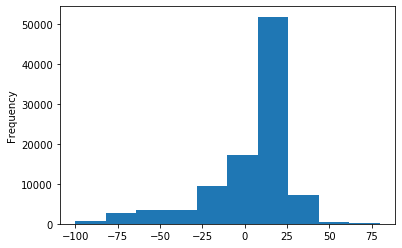

In [10]:
LC_raw.roi.plot.hist()

In [11]:
LC_raw.roi.isna().sum()

0

In [12]:
# total investment $100 per loan
"{:,.0f}".format(LC_raw.roi.count()*100)

'9,677,900'

In [13]:
# total return
"{:,.0f}".format(LC_raw.roi.sum())

'363,126'

In [14]:
# not exactly a 7% return as advertised
# obviously not a good idea to invest in all loans.
"{:,.3f}".format(LC_raw.roi.sum()/(LC_raw.roi.count()*100))

'0.038'

In [15]:
LC_raw.groupby(by="grade")[["roi"]].sum()/(LC_raw.groupby(by="grade")[["roi"]].count()*100)

,roi
grade,
A,0.060095
B,0.060608
C,0.018499
D,0.027083
E,0.018223
F,-0.015308
G,-0.054180


In [16]:
LC_raw.groupby(by="term")[["roi"]].sum()/(LC_raw.groupby(by="term")[["roi"]].count()*100)

,roi
term,
36 months,0.071441
60 months,-0.063268


In [17]:
LC_raw.sort_values(by='roi',ascending=False)[['term','loan_amnt','total_pymnt','roi']].head(20)

,term,loan_amnt,total_pymnt,roi
66861,60 months,20000.0,35933.250000,79.666250
68496,60 months,12625.0,22279.775144,76.473466
15491,60 months,14400.0,25317.510000,75.816042
13115,60 months,20075.0,35275.780000,75.719950
59134,60 months,19600.0,34246.085988,74.724929
17243,60 months,12200.0,21259.730000,74.260082
23246,60 months,30000.0,52233.486763,74.111623
74467,60 months,35000.0,60904.586860,74.013105
23819,60 months,30000.0,52168.922706,73.896409
55653,60 months,15000.0,26049.354111,73.662361


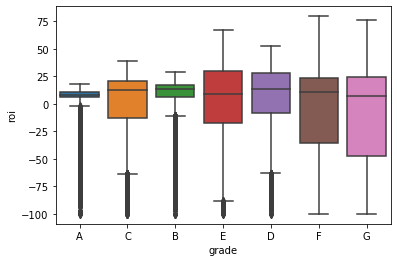

In [18]:
# data is biased because it only includes funded loans.  Clearly some loans will not get funded
import seaborn as sb
sb.boxplot(x=LC_raw.grade,y=LC_raw.roi)

### Feature EDA

Full data list is [here](https://docs.google.com/spreadsheets/d/16fqmVyjloON5Efo51wHtyNodsNwEPvSzkYsUP0QoZm4/edit#gid=1283882092) and sample data [here](https://docs.google.com/spreadsheets/d/13wa-cJcNWSenJAEBTVo9u0DpoiBe7ruVIAiPA2sDnyE/edit#gid=1876307080). From the initial list of data I took the following steps:
1. Narrowed down features from the long list of variables, focusing on features that are avaliable at the time the loan is being requested. In the end, I ended up with 38 features.
2. Classified features as either _continuous_ (including ints values for the most part) or _discrete_
3. Create graphs and identified any transformations
4. looked for nulls and impute 

For the most part these data are amazingly well behaved. Only need a few transformations and imputations. 

"Coded" list of features are in the [Data Dictionary](https://docs.google.com/spreadsheets/d/16fqmVyjloON5Efo51wHtyNodsNwEPvSzkYsUP0QoZm4/edit#gid=1283882092).

More details & visualizations of the EDA are in Appendix A.

#### Categorical variables One-hot encoding 

For the random forest I will use one-hot encoding for all categorical variables.  This will create many hundreds of features to contrast with the embeddings approach.

1.  I include zip-code which is the source of most dummy variables -- the resulting small sample sizes and high cardinality is going to be very difficult for small trees to use effectively.
2.  Term is a categorical variable
3.  sub-grade is a subset of grade and is [colinear to the interest rate](https://www.lendingclub.com/investing/investor-education/interest-rates-and-fees)

In [19]:
LC_raw['term'].value_counts()

 36 months    72410
 60 months    24369
Name: term, dtype: int64

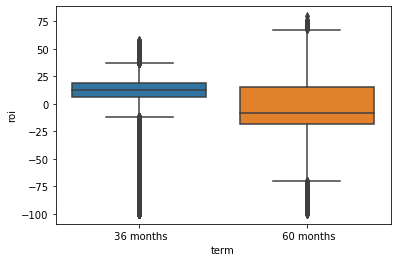

In [20]:
sb.boxplot(x=LC_raw.term,y=LC_raw.roi)

In [21]:
LC_raw.groupby(by="term")[["roi"]].sum()/(LC_raw.groupby(by="term")[["roi"]].count()*100)

,roi
term,
36 months,0.071441
60 months,-0.063268


In [22]:
LC_raw['emp_length'].value_counts()

10+ years    33365
2 years       9052
3 years       8180
< 1 year      6951
1 year        6421
5 years       6042
4 years       5727
6 years       4248
9 years       3580
7 years       3222
8 years       3199
Name: emp_length, dtype: int64

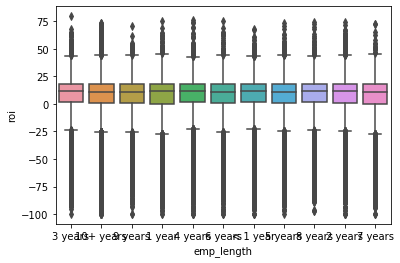

In [23]:
sb.boxplot(x=LC_raw.emp_length,y=LC_raw.roi)

In [24]:
LC_raw.groupby(by="emp_length")[["roi"]].sum()/(LC_raw.groupby(by="emp_length")[["roi"]].count()*100)

,roi
emp_length,
1 year,0.036420
10+ years,0.039755
2 years,0.039316
3 years,0.041003
4 years,0.042366
5 years,0.034735
6 years,0.034969
7 years,0.029341
8 years,0.044841


In [25]:
LC_raw['emp_title'].value_counts().size
LC_raw['emp_title'].value_counts().head(60)

# Categorical TRANSFORMATION: collapse?

Teacher                     1813
Manager                     1620
Owner                       1398
Driver                       756
Registered Nurse             728
RN                           724
Sales                        682
Supervisor                   595
Project Manager              542
owner                        479
General Manager              469
Director                     462
Office Manager               448
President                    414
Operations Manager           317
teacher                      316
Engineer                     314
manager                      287
Vice President               285
Sales Manager                275
Supervisor                   271
Attorney                     268
Accountant                   257
Nurse                        239
Truck Driver                 225
Administrative Assistant     219
Police Officer               212
Account Manager              211
Executive Assistant          204
driver                       203
Technician

In [26]:
LC_raw['home_ownership'].value_counts().size
LC_raw['home_ownership'].value_counts().head(60)

# Categorical transformation: REMOVE NONE

MORTGAGE    48083
RENT        37179
OWN         11135
ANY           381
NONE            1
Name: home_ownership, dtype: int64

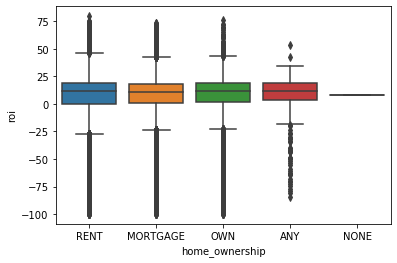

In [27]:
sb.boxplot(x=LC_raw.home_ownership,y=LC_raw.roi)

In [28]:
LC_raw.groupby(by="home_ownership")[["roi"]].sum()/(LC_raw.groupby(by="home_ownership")[["roi"]].count()*100)

,roi
home_ownership,
ANY,0.058835
MORTGAGE,0.038399
NONE,0.083622
OWN,0.042764
RENT,0.034596


In [29]:
LC_raw['purpose'].value_counts().size
LC_raw['purpose'].value_counts().head(60)

debt_consolidation    54811
credit_card           21009
home_improvement       7059
other                  6131
major_purchase         2172
medical                1353
small_business         1145
car                    1118
vacation                780
moving                  704
house                   429
renewable_energy         68
Name: purpose, dtype: int64

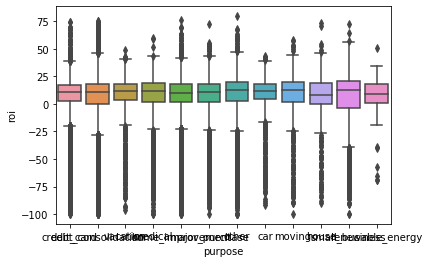

In [30]:
sb.boxplot(x=LC_raw.purpose,y=LC_raw.roi)

In [31]:
LC_raw.groupby(by="purpose")[["roi"]].sum()/(LC_raw.groupby(by="purpose")[["roi"]].count()*100)

,roi
purpose,
car,0.066591
credit_card,0.038885
debt_consolidation,0.034165
home_improvement,0.037314
house,0.025365
major_purchase,0.042782
medical,0.032236
moving,0.055515
other,0.054671


In [32]:
LC_raw['title'].value_counts().size
LC_raw['title'].value_counts().head(60)

Debt consolidation         54807
Credit card refinancing    21017
Home improvement            7058
Other                       6130
Major purchase              2167
Medical expenses            1353
Business                    1146
Car financing               1121
Vacation                     780
Moving and relocation        704
Home buying                  429
Green loan                    67
Name: title, dtype: int64

In [33]:
LC_raw.groupby(by="title")[["roi"]].sum()/(LC_raw.groupby(by="title")[["roi"]].count()*100)

,roi
title,
Business,0.034113
Car financing,0.067080
Credit card refinancing,0.038941
Debt consolidation,0.034145
Green loan,0.052733
Home buying,0.025365
Home improvement,0.037286
Major purchase,0.042544
Medical expenses,0.032236


In [34]:
LC_raw['verification_status'].value_counts().head(60)

Source Verified    39703
Not Verified       29531
Verified           27545
Name: verification_status, dtype: int64

In [35]:
LC_raw.groupby(by="verification_status")[["roi"]].sum()/(LC_raw.groupby(by="verification_status")[["roi"]].count()*100)

,roi
verification_status,
Not Verified,0.040441
Source Verified,0.044864
Verified,0.023808


### Create one-hot-encodings

In [36]:
categorical_features = [
    'term'
    ,'emp_length'
    ,'grade'
    ,'home_ownership'
    ,'purpose'
    ,'sub_grade'
    ,'title'
    ,'verification_status'
]

# unable to do the one-hot on these:
# 'zip_code',
# 'addr_state',
# ,'emp_title'

In [37]:
LC_raw.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,roi
0,104160129,NaN,6000.0,6000.0,6000.0,36 months,7.24%,185.93,A,A3,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,9.218622
1,104170260,NaN,17000.0,17000.0,17000.0,36 months,7.49%,528.73,A,A4,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,1.663546
2,103952006,NaN,14000.0,14000.0,14000.0,60 months,12.74%,316.69,C,C1,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,-54.369286
3,103347407,NaN,9900.0,9900.0,9900.0,36 months,5.32%,298.14,A,A1,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,5.775280
4,103470623,NaN,15400.0,15400.0,15400.0,60 months,11.39%,337.84,B,B3,...,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,17.876046


In [38]:
# ok this did not work on my machine except for too small samples
LC_train_catx = pd.get_dummies(LC_raw[categorical_features])

# d1 = pd.get_dummies(LC_raw_cats[['term','emp_length']])
# LC_raw['emp_title'].value_counts()
# d2 = pd.get_dummies(LC_raw_cats[['emp_title']])

In [39]:
LC_train_catx.head()

,term_ 36 months,term_ 60 months,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,...,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [40]:
len(LC_train_catx.columns)

87

#### Continuous features

Only a few require transformations:
1. Several convert to 0/1 since they have very few non-zero entries.
2. Interest rate needs to be converted to a float value.
3. Some of these probably could use a log or sqrt transformation but I am going to ignore the skewness for now. I should update later. _**tag:TODO=deal with skewness**_

In [41]:
LC_train_numx = LC_raw[['int_rate',
'annual_inc',
'delinq_2yrs',
'dti',
'fico_range_high',
'fico_range_low',
'inq_last_6mths',
'loan_amnt',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'total_bal_ex_mort',
'acc_now_delinq',
'installment',
'collections_12_mths_ex_med',
'inq_last_12m',
'num_bc_tl',
'num_op_rev_tl',
'num_tl_op_past_12m',
'percent_bc_gt_75',
'revol_bal',
'tax_liens',
'tot_hi_cred_lim',
'total_bc_limit',
'pub_rec_bankruptcies']]

In [42]:
# these throw an warning but seem to work, there is probably a better way to do this
LC_train_numx.loc[:,'acc_now_delinq'] = ((LC_raw['acc_now_delinq'] > 0).astype(int))
LC_train_numx['collections_12_mths_ex_med'] = (LC_train_numx['collections_12_mths_ex_med']>0).astype(int)
LC_train_numx.loc[:,'tax_liens'] = ((LC_train_numx['tax_liens'] > 0).astype(int))
LC_train_numx.loc[:,'pub_rec_bankruptcies'] = ((LC_train_numx['pub_rec_bankruptcies'] > 0).astype(int))



/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### convert to 0/1

In [43]:
LC_train_numx['acc_now_delinq'].value_counts()

0    96176
1      603
Name: acc_now_delinq, dtype: int64

#### change int_rate from string to float

In [44]:
## Interest rate
## this also throws a warning but seems to work
LC_train_numx['int_rate'] = LC_train_numx['int_rate'].str.replace('%','',regex=False).astype(float)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


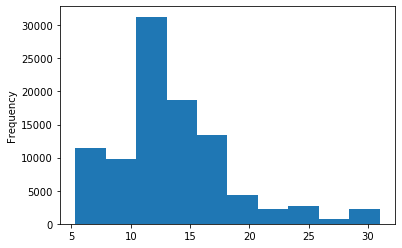

In [45]:
LC_train_numx['int_rate'].plot.hist()

#### Missing values
1. imputation done by context, not statistical imputation (_e.g._ median or average)
1. for recency variables I use 999 because larger numbers should be "better" (never do this with a linear model)



In [46]:
for col in LC_train_numx.columns:
    print(col," ",LC_train_numx[col].isna().sum())

int_rate   0
annual_inc   0
delinq_2yrs   0
dti   33
fico_range_high   0
fico_range_low   0
inq_last_6mths   0
loan_amnt   0
mths_since_last_delinq   46293
mths_since_last_record   77674
open_acc   0
pub_rec   0
total_acc   0
total_bal_ex_mort   0
acc_now_delinq   0
installment   0
collections_12_mths_ex_med   0
inq_last_12m   0
num_bc_tl   0
num_op_rev_tl   0
num_tl_op_past_12m   0
percent_bc_gt_75   987
revol_bal   0
tax_liens   0
tot_hi_cred_lim   0
total_bc_limit   0
pub_rec_bankruptcies   0


In [47]:
values = {'dti': 99, 'percent_bc_gt_75': 0, 'mths_since_last_delinq': 999, 'mths_since_last_record': 999}
LC_train_numx = LC_train_numx.fillna(value=values)

### Bring all features together into feature dataset

In [48]:
LC_train_x = pd.concat([LC_train_numx,LC_train_catx], axis=1, sort=False)
feature_list = list(LC_train_x.columns)

In [49]:
#114 features!
LC_train_x

,int_rate,annual_inc,delinq_2yrs,dti,fico_range_high,fico_range_low,inq_last_6mths,loan_amnt,mths_since_last_delinq,mths_since_last_record,...,title_Home buying,title_Home improvement,title_Major purchase,title_Medical expenses,title_Moving and relocation,title_Other,title_Vacation,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,7.24,125000.0,0.0,9.25,694.0,690.0,1.0,6000.0,54.0,999.0,...,0,0,0,0,0,0,0,0,1,0
1,7.49,120000.0,0.0,8.41,739.0,735.0,0.0,17000.0,72.0,89.0,...,0,0,0,0,0,0,0,1,0,0
2,12.74,49960.0,0.0,9.30,719.0,715.0,0.0,14000.0,999.0,90.0,...,0,0,0,0,0,0,0,1,0,0
3,5.32,53000.0,1.0,19.47,734.0,730.0,0.0,9900.0,16.0,999.0,...,0,0,0,0,0,0,0,1,0,0
4,11.39,95000.0,0.0,11.52,734.0,730.0,0.0,15400.0,34.0,999.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96774,21.49,60000.0,1.0,43.00,674.0,670.0,3.0,30000.0,11.0,999.0,...,0,0,0,0,0,0,0,0,0,1
96775,12.74,110500.0,0.0,4.95,679.0,675.0,2.0,15000.0,999.0,999.0,...,0,0,0,0,0,0,0,0,1,0
96776,8.24,46203.0,0.0,17.04,674.0,670.0,0.0,10000.0,38.0,999.0,...,0,0,0,0,0,0,0,1,0,0
96777,15.99,24564.0,2.0,21.38,709.0,705.0,0.0,6325.0,15.0,999.0,...,0,0,0,0,0,0,0,1,0,0


### Label 

In [50]:
LC_train_y = LC_raw[['roi']]
LC_train_y

,roi
0,9.218622
1,1.663546
2,-54.369286
3,5.775280
4,17.876046
...,...
96774,26.626001
96775,12.254860
96776,13.132206
96777,26.979562


## Random forest baseline model


#### Convert data to numpy -- RF from skicit learn likes numpy

In [51]:
import numpy as np

LC_train_x = np.array(LC_train_x)
type(LC_train_x)

numpy.ndarray

In [52]:
LC_train_y = np.array(LC_train_y)
type(LC_train_y)

numpy.ndarray

### Training and testing datasets

Split the data into train and test sets. Quick check on sample sizes.

Obviously code that I downloaded from the internets since I suddenly start using different definitions (target vs. labels).

In [53]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(LC_train_x, LC_train_y, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape,". Type:",type(train_features))
print('Training Labels Shape:', train_labels.shape,". Type:",type(train_labels))
print('Testing Features Shape:', test_features.shape,". Type:",type(test_features))
print('Testing Labels Shape:', test_labels.shape,". Type:",type(test_labels))

Training Features Shape: (72584, 114) . Type: <class 'numpy.ndarray'>
Training Labels Shape: (72584, 1) . Type: <class 'numpy.ndarray'>
Testing Features Shape: (24195, 114) . Type: <class 'numpy.ndarray'>
Testing Labels Shape: (24195, 1) . Type: <class 'numpy.ndarray'>


#### Train random forest

ravel() is to convert train_labels from the array shape to (n, )

In [61]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 200
                           ,max_depth=6
                           ,min_samples_split=100
                           ,min_samples_leaf=20
                           ,random_state = 39281
                          ,verbose = 1)

# max_depth=None, min_samples_split=2, min_samples_leaf=1 # verbose=0
rf.fit(train_features, train_labels.ravel());

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  1.9min finished


#### RF Predictions

In [62]:
predictions = rf.predict(test_features)
type(predictions)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished


numpy.ndarray

In [63]:
predictions

array([-5.87157403,  6.69573776,  8.18325059, ...,  8.56061271,
        8.92492251, -4.85588767])

## RF Validation 

1. Bias - are the predictions unbiased?
2. Loss function: what is the cost of a false-negative and -positive.
1. Confusion matrix
3. Most sensible accuracy measure
3. Interpretation - features vs. actual and predictions

In [64]:
predictions.sum()

90648.03732249384

In [65]:
test_labels.sum()

92165.88503151046

In [59]:
predictions.shape


(24195,)

In [89]:
test_labels[:,0].shape

(250,)

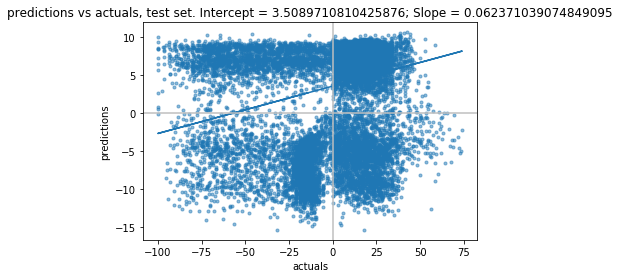

In [66]:
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit

area = np.pi*3

plt.scatter(x=test_labels, y=predictions, s=area, alpha=0.5)


# this is a bit annoying but test_labels has 2 dimensions for some reason, try test_labels.shape
b, m = polyfit(x=test_labels[:,0],y=predictions,deg=1)

plt.plot(test_labels, b + m * test_labels, '-')
plt.axhline(y=0,color = '0.75')
plt.axvline(x=0,color = '0.75')

plt.title("predictions vs actuals, test set. Intercept = {}; Slope = {}".format(b,m))
plt.xlabel('actuals')
plt.ylabel('predictions')

plt.show()

In [68]:
feature_list = list(LC_train_x.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

NameError: name 'feature_list' is not defined

#### Goal and loss function

Goal is to make as large a return as possible with a fixed investment

The approach is similar to portfolio optimization

**_tag:HERE_**

In [31]:
from sklearn.metrics import confusion_matrix

predicted_pay = (predictions > 0.5).astype(int)
confusion_matrix(test_labels, predicted_pay)

array([[46, 62],
       [50, 92]])

In [150]:
type(test_labels)

numpy.ndarray

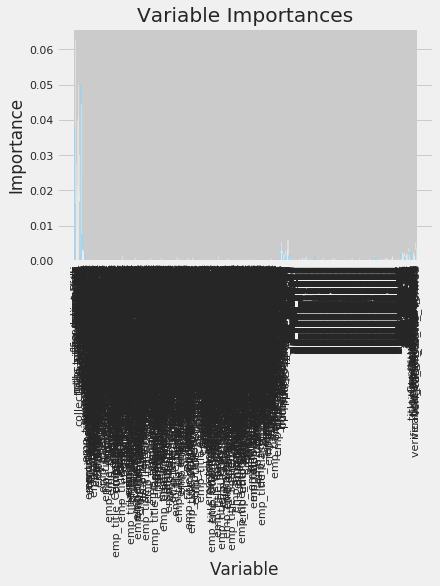

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

ax = sns.boxplot(x=LC_train_x['int_rate'])

ax = sns.boxplot(x="grade", y="int_rate", data=LC_train_x)

### 62 false positives

In [152]:
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), '%.')

Mean Absolute Error: 0.49 %.


### that is not good

### Appendix A - feature EDA

In [67]:
# LC_raw['int_rate'].head()

LC_raw['int_rate'] = LC_raw['int_rate'].str.replace('%','',regex=False).astype(float)
LC_raw['int_rate'].value_counts()

11.49    90
12.74    76
8.24     71
15.99    70
13.49    62
11.44    62
10.49    61
14.99    58
11.39    54
13.99    54
5.32     53
7.49     43
18.99    38
7.99     36
6.99     34
16.99    32
7.24     20
17.99    19
19.99    14
22.74    12
23.99    11
25.49     9
28.69     5
24.74     4
29.99     4
26.24     2
29.49     1
30.74     1
30.89     1
30.84     1
Name: int_rate, dtype: int64

In [69]:
LC_raw['int_rate'].isna().sum()

0

In [70]:
 # LC_raw['int_rate'].head()
LC_raw['term'].value_counts()

 36 months    756
 60 months    242
Name: term, dtype: int64

In [71]:
LC_raw['term'].isna().sum()

0

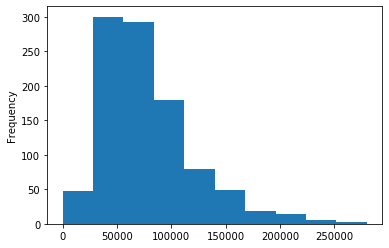

In [75]:
LC_raw['annual_inc'][LC_raw.annual_inc < 300000].plot.hist()

In [73]:
LC_raw['annual_inc'].isna().sum()

0

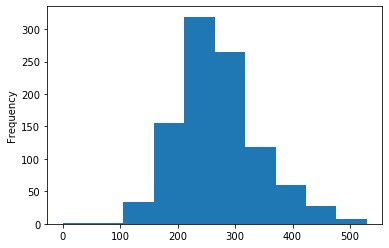

In [79]:
(LC_raw['annual_inc'][LC_raw.annual_inc < 300000]**(1/2)).plot.hist()

In [80]:
LC_raw['delinq_2yrs'].value_counts()


0    780
1    148
2     39
3     14
4      7
6      6
5      3
7      1
Name: delinq_2yrs, dtype: int64

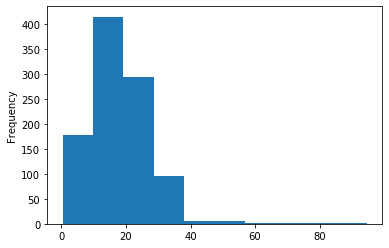

In [83]:
LC_raw['dti'].plot.hist()


In [69]:
LC_raw[LC_raw.dti.isna() == True][['dti','loan_amnt','annual_inc']]

,dti,loan_amnt,annual_inc
482,NaN,12000,0.0
923,NaN,10000,0.0


In [84]:
### TODO change this to recency

LC_raw['earliest_cr_line'].value_counts()

Jun-2003    10
Apr-2004     9
Feb-2002     9
Dec-2001     8
Feb-2007     8
            ..
Jun-2009     1
Mar-1979     1
Jun-1987     1
Aug-1985     1
May-1985     1
Name: earliest_cr_line, Length: 339, dtype: int64

In [86]:
LC_raw['emp_length'].value_counts()

10+ years    371
3 years       90
2 years       87
< 1 year      64
4 years       62
1 year        59
5 years       54
6 years       41
9 years       37
8 years       32
7 years       29
Name: emp_length, dtype: int64

In [87]:
## embedding
LC_raw['emp_title'].value_counts()

Manager                                  16
Teacher                                  16
Owner                                    10
Driver                                   10
Office Manager                            8
                                         ..
Benefit consultant                        1
Medical Laboratory Technician             1
Operations Services Senior Specialist     1
GENERAL PARTNER                           1
Consultant                                1
Name: emp_title, Length: 746, dtype: int64

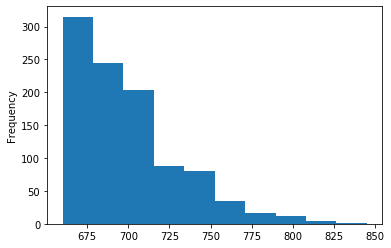

In [88]:
LC_raw['fico_range_low'].plot.hist()

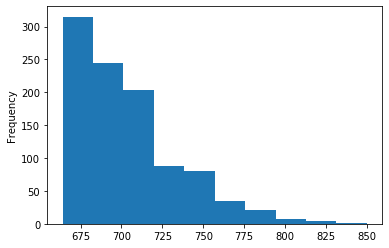

In [89]:
LC_raw['fico_range_high'].plot.hist()

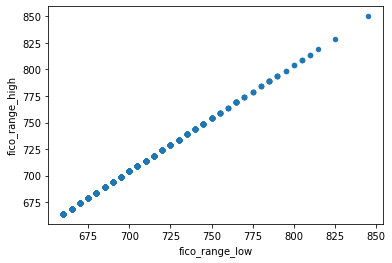

In [90]:
LC_raw.plot.scatter(x='fico_range_low',y='fico_range_high')

In [91]:
LC_raw['grade'].value_counts()

B    338
C    320
A    186
D    103
E     38
F     11
G      2
Name: grade, dtype: int64

In [92]:
LC_raw['sub_grade'].value_counts()

B5    90
C1    76
B1    71
C5    70
B4    62
C2    62
B2    61
C4    58
C3    54
B3    54
A1    53
A4    43
D3    38
A5    36
A2    34
D1    32
A3    20
D2    19
D4    14
E1    12
E2    11
E4     9
F1     5
E3     4
F3     4
E5     2
G2     1
F2     1
G3     1
F5     1
Name: sub_grade, dtype: int64

In [93]:
LC_raw['home_ownership'].value_counts()

MORTGAGE    509
RENT        382
OWN         107
Name: home_ownership, dtype: int64

In [94]:
LC_raw['inq_last_6mths'].value_counts()

0    627
1    265
2     81
3     19
4      6
Name: inq_last_6mths, dtype: int64

In [95]:
LC_raw['issue_d'].value_counts()

Mar-2017    998
Name: issue_d, dtype: int64

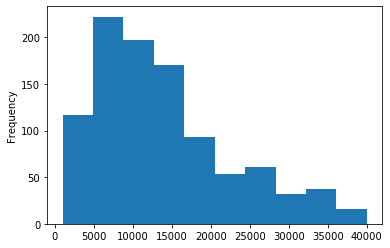

In [97]:
LC_raw['loan_amnt'].plot.hist()

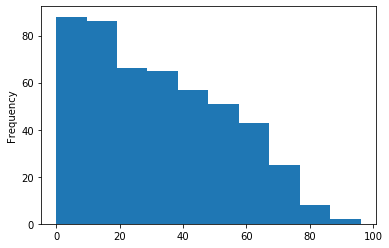

In [98]:
LC_raw['mths_since_last_delinq'].plot.hist()

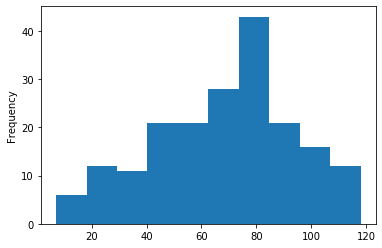

In [99]:
LC_raw['mths_since_last_record'].plot.hist()

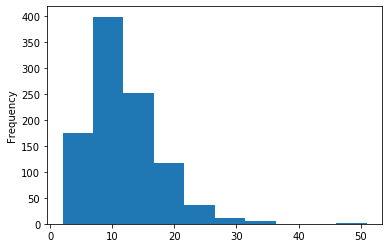

In [100]:
LC_raw['open_acc'].plot.hist()


In [101]:
LC_raw['open_acc'].isna().sum()

0

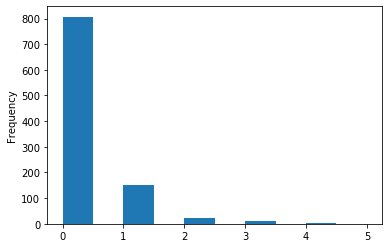

In [102]:
LC_raw['pub_rec'].plot.hist()

In [103]:
LC_raw['purpose'].value_counts()

debt_consolidation    562
credit_card           221
other                  71
home_improvement       70
major_purchase         23
medical                15
vacation               13
car                     8
moving                  7
small_business          5
house                   3
Name: purpose, dtype: int64

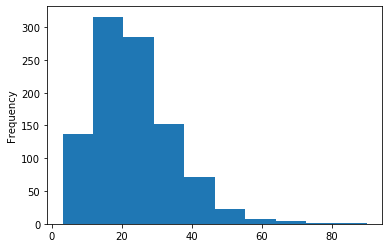

In [105]:
LC_raw['total_acc'].plot.hist()

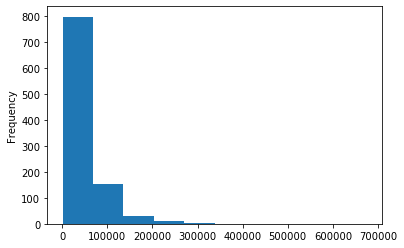

In [106]:
LC_raw['total_bal_ex_mort'].plot.hist()

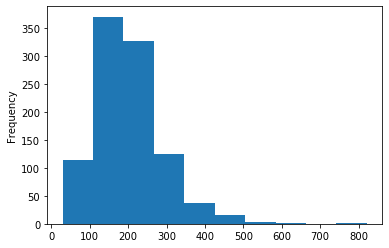

In [107]:
(LC_raw['total_bal_ex_mort']**(1/2)).plot.hist()

In [108]:
LC_raw['zip_code'].value_counts()

945xx    18
070xx    13
088xx    13
112xx    12
921xx    11
         ..
226xx     1
304xx     1
932xx     1
768xx     1
547xx     1
Name: zip_code, Length: 410, dtype: int64

In [109]:
LC_raw['acc_now_delinq'].value_counts()

0    993
1      5
Name: acc_now_delinq, dtype: int64

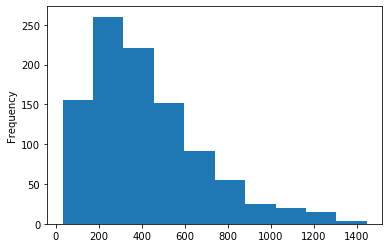

In [112]:
LC_raw['installment'].plot.hist()

In [114]:
LC_raw['collections_12_mths_ex_med'].value_counts()

0    976
1     20
5      1
2      1
Name: collections_12_mths_ex_med, dtype: int64

In [115]:
LC_raw['addr_state'].value_counts()

CA    155
NY     86
TX     79
FL     72
NJ     50
IL     40
PA     38
MD     32
GA     31
OH     29
NC     22
MI     22
CT     19
MN     19
AZ     19
CO     18
IN     18
WA     17
MO     17
MA     16
VA     16
AL     15
TN     14
WI     14
NV     14
OR     13
SC     11
UT     11
OK     10
MS      9
KS      8
LA      7
AR      7
KY      6
HI      6
RI      5
NH      5
VT      4
MT      4
NE      3
WY      3
DC      2
ME      2
AK      2
SD      2
DE      2
ND      2
NM      1
ID      1
Name: addr_state, dtype: int64

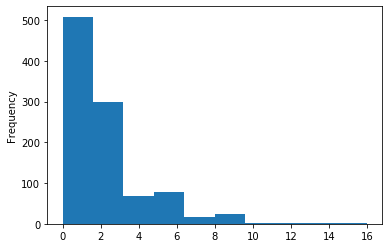

In [116]:

LC_raw['inq_last_12m'].plot.hist()


In [117]:
LC_raw['inq_last_12m'].isna().sum()

0

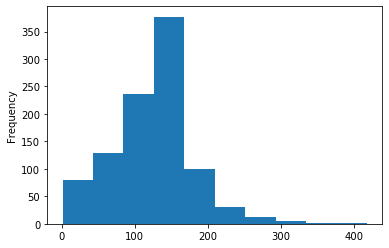

In [118]:
LC_raw['mo_sin_old_il_acct'].plot.hist()


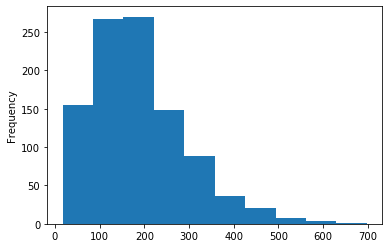

In [119]:
LC_raw['mo_sin_old_rev_tl_op'].plot.hist()


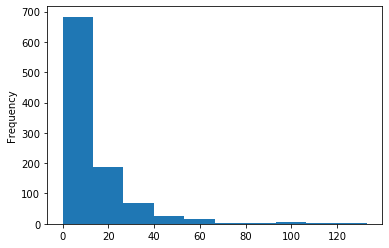

In [120]:
LC_raw['mo_sin_rcnt_rev_tl_op'].plot.hist()

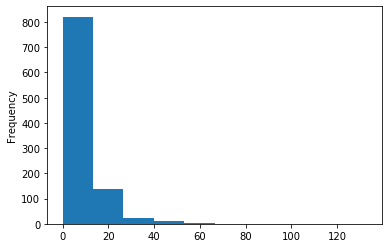

In [121]:
LC_raw['mo_sin_rcnt_tl'].plot.hist()

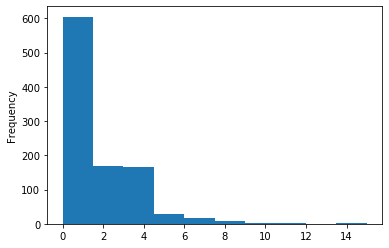

In [122]:
LC_raw['mort_acc'].plot.hist()

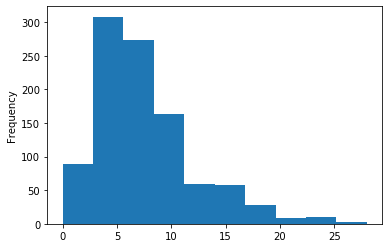

In [125]:
LC_raw['num_bc_tl'].plot.hist()

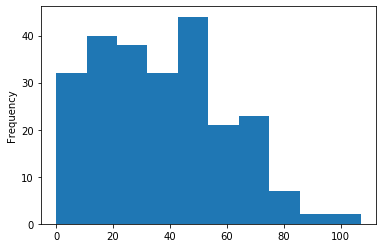

In [124]:
LC_raw['mths_since_recent_bc_dlq'].plot.hist()


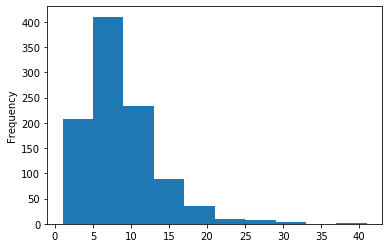

In [126]:
LC_raw['num_op_rev_tl'].plot.hist()

In [129]:
LC_raw['num_tl_op_past_12m'].value_counts()


2     235
1     232
0     199
3     158
4      83
5      42
6      24
7      10
9       7
8       5
13      1
12      1
11      1
Name: num_tl_op_past_12m, dtype: int64

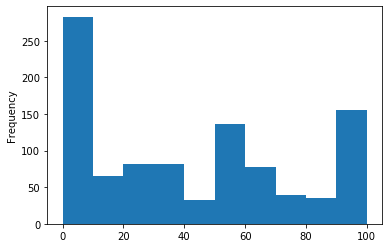

In [130]:
LC_raw['percent_bc_gt_75'].plot.hist()


In [72]:
LC_raw[LC_raw.percent_bc_gt_75.isna() == True][['percent_bc_gt_75','num_bc_tl','total_bc_limit']]



,percent_bc_gt_75,num_bc_tl,total_bc_limit
89,NaN,1,0
134,NaN,0,0
228,NaN,2,0
389,NaN,2,0
392,NaN,3,0
682,NaN,5,0
719,NaN,1,0
927,NaN,0,0
938,NaN,1,0


In [131]:
LC_raw['pub_rec_bankruptcies'].value_counts()

0    875
1    116
2      6
3      1
Name: pub_rec_bankruptcies, dtype: int64

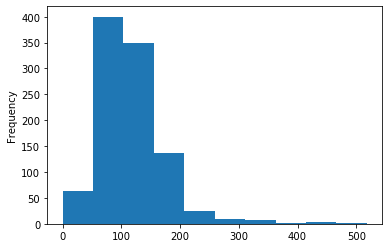

In [146]:
import numpy as np
# np.log(LC_raw['revol_bal']).to_frame().plot.hist()
(LC_raw['revol_bal']**(1/2)).plot.hist()

In [147]:
LC_raw['tax_liens'].value_counts()


0    950
1     28
2      9
3      7
4      3
5      1
Name: tax_liens, dtype: int64

In [148]:
LC_raw['title'].value_counts()


Debt consolidation         562
Credit card refinancing    221
Other                       71
Home improvement            70
Major purchase              23
Medical expenses            15
Vacation                    13
Car financing                8
Moving and relocation        7
Business                     5
Home buying                  3
Name: title, dtype: int64

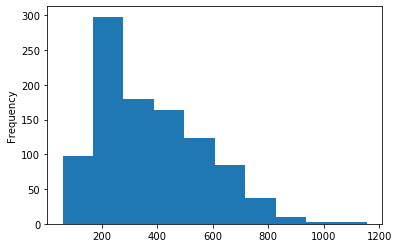

In [150]:
# LC_raw['tot_hi_cred_lim'].plot.hist()

(LC_raw['tot_hi_cred_lim']**(1/2)).plot.hist()

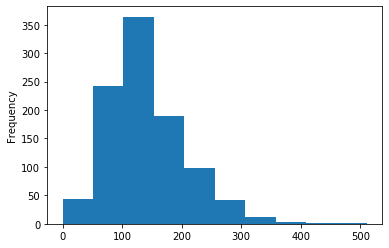

In [151]:
(LC_raw['total_bc_limit']**(1/2)).plot.hist()


In [152]:
LC_raw['verification_status'].value_counts()



Source Verified    414
Not Verified       366
Verified           218
Name: verification_status, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 152 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   id                                          int64  
 1   member_id                                   float64
 2   loan_amnt                                   int64  
 3   funded_amnt                                 int64  
 4   funded_amnt_inv                             int64  
 5   term                                        object 
 6   int_rate                                    float64
 7   installment                                 float64
 8   grade                                       object 
 9   sub_grade                                   object 
 10  emp_title                                   object 
 11  emp_length                                  object 
 12  home_ownership                              object 
 13  annual_inc                        